In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

In [8]:
from models.BNNs.DeterministicNN import Deterministic_NN

In [9]:
def plot_preds(preds, title='', fs=16):
    # plot the fit
    fs = 16

    m = preds.mean(0).to('cpu')
    s = preds.std(0).to('cpu')
    s_al = (preds.var(0).to('cpu') + beta ** -1) ** 0.5

    f, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Get upper and lower confidence bounds
    lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
    # + aleotoric
    lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

    # Plot training data as black stars
    ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
    # Plot predictive means as blue line
    ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
    ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
    ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
    ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
    plt.grid()
    ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_title(title, fontsize=fs)

    plt.tight_layout()
    

In [10]:
def subplot_preds(preds_1, preds_2, title_1='', title_2='', fs=12):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot 1
    m_1 = preds_1.mean(0).to('cpu')
    s_1 = preds_1.std(0).to('cpu')
    s_al_1 = (preds_1.var(0).to('cpu') + beta ** -1) ** 0.5

    # Get upper and lower confidence bounds
    lower_1, upper_1 = (m_1 - s_1*2).flatten(), (m_1 + s_1*2).flatten()
    # + aleotoric
    lower_al_1, upper_al_1 = (m_1 - s_al_1*2).flatten(), (m_1 + s_al_1*2).flatten()

    # Plot training data as black stars
    ax1.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
    # Plot predictive means as blue line
    ax1.plot(xs.numpy(), m_1.numpy(), 'b', rasterized=True)
    ax1.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
    ax1.fill_between(xs.flatten().numpy(), lower_1.numpy(), upper_1.numpy(), alpha=0.5, rasterized=True)
    ax1.fill_between(xs.flatten().numpy(), lower_al_1.numpy(), upper_al_1.numpy(), alpha=0.2, rasterized=True)
    plt.grid()
    ax1.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='both', which='minor', labelsize=14)
    ax1.set_title(title_1, fontsize=fs)
    
    # plot 2
    m_2 = preds_2.mean(0).to('cpu')
    s_2 = preds_2.std(0).to('cpu')
    s_al_2 = (preds_2.var(0).to('cpu') + beta ** -1) ** 0.5

    # Get upper and lower confidence bounds
    lower_2, upper_2 = (m_2 - s_2*2).flatten(), (m_2 + s_2*2).flatten()
    # + aleotoric
    lower_al_2, upper_al_2 = (m_2 - s_al_2*2).flatten(), (m_2 + s_al_2*2).flatten()

    # Plot training data as black stars
    ax2.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
    # Plot predictive means as blue line
    ax2.plot(xs.numpy(), m_2.numpy(), 'b', rasterized=True)
    ax2.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
    ax2.fill_between(xs.flatten().numpy(), lower_2.numpy(), upper_2.numpy(), alpha=0.5, rasterized=True)
    ax2.fill_between(xs.flatten().numpy(), lower_al_2.numpy(), upper_al_2.numpy(), alpha=0.2, rasterized=True)
    plt.grid()
    ax2.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='minor', labelsize=14)
    ax2.set_title(title_2, fontsize=fs)
    plt.tight_layout()

In [11]:
# create toy dataset
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(20)
x = torch.cat([torch.Tensor(75).uniform_(-5, -2).sort()[0].reshape(-1, 1),
               torch.Tensor(50).uniform_(2, 5).sort()[0].reshape(-1, 1)])
i = 30
x_data = torch.cat([x[0:i - 15], x[i + 14:]])

# generate some data
alpha, beta, num_nodes = 1., 100., 2

# generate some data
data_generator_model = Deterministic_NN(alpha=alpha, beta=beta, num_nodes=num_nodes)
sampled_weights = data_generator_model.sample_weights_from_prior()
data_generator_model.make_weights_from_sample(sampled_weights)
y_data = data_generator_model(x_data).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_data).detach())

x_test = torch.Tensor(200).uniform_(-10., 10.).sort()[0]
y_test = data_generator_model(x_test).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_test).detach()).sort()[0]

xs = torch.linspace(-10, 10, 100)
ys = data_generator_model(xs).detach()

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/pyro/distributions/torch_patch.py:81: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  return torch.stack([v.symeig(eigenvectors=False)[0][:1] > 0.0


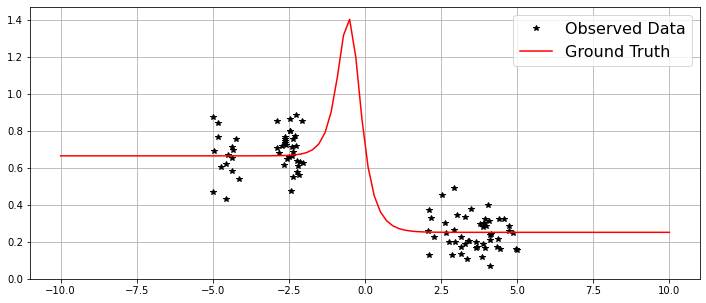

In [12]:
plt.figure(figsize=(12,5))
plt.plot(x_data,y_data, 'k*')
plt.plot(xs, ys, 'r')
plt.legend(['Observed Data', 'Ground Truth'], fontsize = 16)
plt.grid()
plt.show()

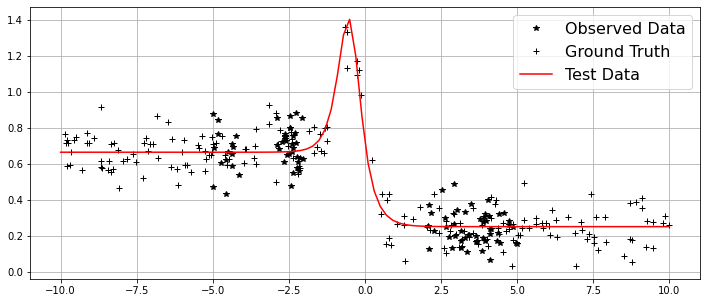

In [13]:
plt.figure(figsize=(12,5))
plt.plot(x_data,y_data, 'k*')
plt.plot(x_test,y_test, 'k+')
plt.plot(xs, ys, 'r')
plt.legend(['Observed Data', 'Ground Truth', 'Test Data'], fontsize = 16)
plt.grid()
plt.show()

In [14]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(0))

device  =torch.device('cpu')
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x.view(-1, 1)))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(num_nodes=num_nodes)

In [15]:
step_size = 0.009
num_samples = 5000
L = 10
burn = 1000
store_on_GPU = False
debug = False
model_loss = 'regression'
mass = 1.0

# Effect of tau
# Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
# Set to tau = 1. for more flexible

ELBO_BETA = 25.
tau = alpha # Prior Precision
tau_out = beta * 1./ELBO_BETA # Output Precision
r = 0 # Random seed


tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

# Set initial weights
params_init = hamiltorch.util.flatten(net).to(device).clone()
# Set the Inverse of the Mass matrix
inv_mass = torch.ones(params_init.shape) / mass

In [16]:
print(params_init.shape)
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC

hamiltorch.set_random_seed(r)
params_hmc_f = hamiltorch.sample_model(net, x_data.to(device), y_data.to(device), params_init=params_init,
                                       model_loss=model_loss, num_samples=num_samples,
                                       burn = burn, inv_mass=inv_mass.to(device),step_size=step_size,
                                       num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list,
                                       debug=debug, store_on_GPU=store_on_GPU,
                                       sampler = sampler)

# At the moment, params_hmc_f is on the CPU so we move to GPU

params_hmc_gpu = [ll.to(device) for ll in params_hmc_f[1:]]


# Let's predict over the entire test range [-2,2]
pred_list_hmc, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=params_hmc_gpu,
                                                  model_loss=model_loss, tau_out=beta,
                                                  tau_list=tau_list)
# Let's evaluate the performance over the training data
pred_list_tr, log_probs_split_tr = hamiltorch.predict_model(net, x = x_data.to(device), y=y_data.to(device),
                                                            samples=params_hmc_gpu, model_loss=model_loss,
                                                            tau_out=beta, tau_list=tau_list)
ll_full = torch.zeros(pred_list_tr.shape[0])
ll_full[0] = - 0.5 * tau_out * ((pred_list_tr[0].cpu() - y_data) ** 2).sum(0)
for i in range(pred_list_tr.shape[0]):
    ll_full[i] = - 0.5 * tau_out * ((pred_list_tr[:i].mean(0).cpu() - y_data) ** 2).sum(0)

torch.Size([13])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:01:13 | 0d:00:00:00 | #################### | 5000/5000 | 67.78       
Acceptance Rate 0.99


In [17]:
ll_full = torch.zeros(pred_list_tr.shape[0])
ll_full[0] = - 0.5 * beta * ((pred_list_tr[0].cpu() - y_data) ** 2).sum(0)
for i in range(pred_list_tr.shape[0]):
    ll_full[i] = - 0.5 * tau_out * ((pred_list_tr[:i].mean(0).cpu() - y_data) ** 2).sum(0)

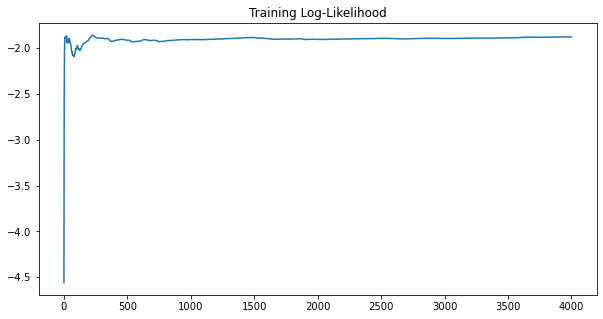

In [18]:
f, ax1 = plt.subplots(1,1, figsize = (10,5))
ax1.set_title('Training Log-Likelihood')
ax1.plot(ll_full)

In [19]:
# Let's predict over the entire test range [-2,2]
pred_list_hmc, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=params_hmc_gpu,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)

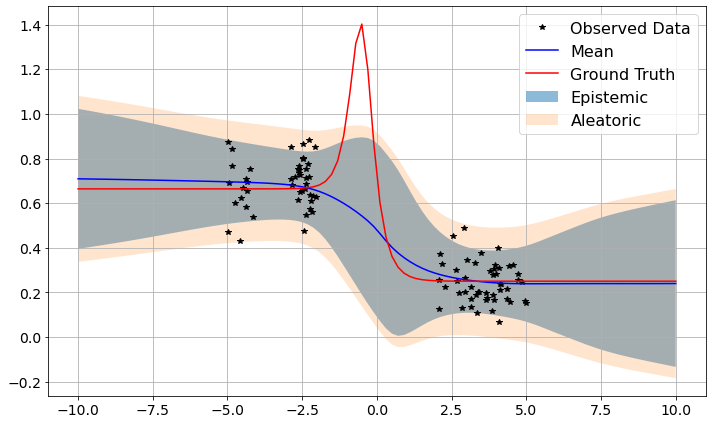

In [20]:
plot_preds(pred_list_hmc)

# Draw subset of samples

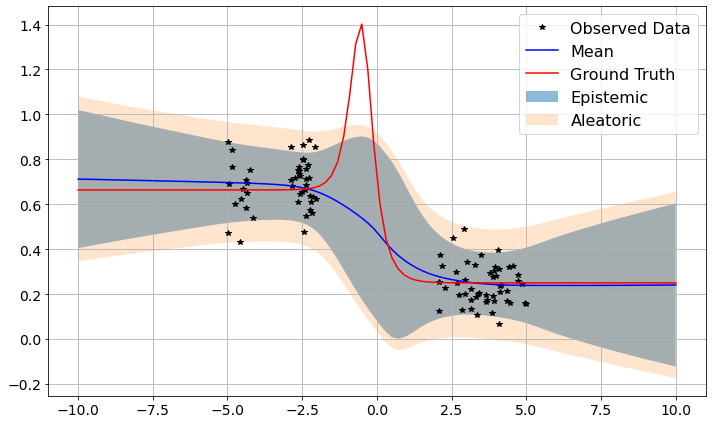

In [21]:
import random
random.seed(0)
subset = random.sample(params_hmc_gpu, 1000)
# Let's predict over the entire test range [-2,2]
pred_list_hmc_subsample, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=subset,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_hmc_subsample)

In [22]:
emp_samples = torch.empty([0])
for s in subset:
    emp_samples = torch.cat([emp_samples, s[None]])

# Let's try the KDE coder

In [23]:
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.KDEPosterior import KDEPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.beamsearch.Coders.Encoder_KDE import EncoderKDE

In [24]:
# find optimal kde_var
from models.BNNs.BNN_KDE import BNN_KDE

bnn_kde = BNN_KDE(emp_samples, alpha=alpha, beta=beta, kl_beta=ELBO_BETA)

num_epochs = 5000
num_parallel_samples = 128
optimiser = torch.optim.Adamax(bnn_kde.parameters(), lr=5e-2)
for i in range(num_epochs):
    optimiser.zero_grad()
    loss = -bnn_kde.elbo(x_data, y_data, num_parallel_samples)
    if i % 1000 == 0:
        print(f'The loss is: {loss.item():.5f}, val of var is: {torch.exp(bnn_kde.log_kde_std)[0].item() ** 2:.5f}')
    loss.backward()
    optimiser.step()

The loss is: 2340.30374, val of var is: 0.13534
The loss is: 664.71024, val of var is: 0.00846
The loss is: 694.01042, val of var is: 0.00889
The loss is: 700.92651, val of var is: 0.00858
The loss is: 703.03928, val of var is: 0.00916


In [25]:
KDE_var = torch.exp(bnn_kde.log_kde_std)[0].item() ** 2
#n_samples = 100
KDE_weights = dist.Categorical(torch.ones(emp_samples.shape[0]))
initial_seed = 0
torch.manual_seed(initial_seed)
KDE_components = dist.MultivariateNormal(loc=emp_samples,
                                         covariance_matrix=KDE_var * torch.eye(emp_samples.shape[-1]))

KDE_target = dist.MixtureSameFamily(KDE_weights, KDE_components)

In [26]:
from rec.utils import kl_estimate_with_mc
prior = D.MultivariateNormal(loc=torch.zeros_like(emp_samples[0]), covariance_matrix = 1./alpha * torch.eye(emp_samples.shape[-1]))
kl_q_p = kl_estimate_with_mc(KDE_target, prior)
print(f"{kl_q_p}")

23.776032172369806


# Lets optimise the variances

In [27]:
#lets compress some samples
#### sample weights with compression algorithm
from tqdm.notebook import trange
from rec.beamsearch.Coders.Encoder_Empirical import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling_BNNs import GreedySampler
from models.BNNs.BNN_for_HMC import BNN_for_HMC
import pyro.distributions as dist

In [28]:
dummy_model = BNN_for_HMC(alpha=alpha, beta=beta, num_nodes=num_nodes)

In [29]:
# import pickle as pkl
# pkl.dump(emp_samples, open("PickledStuff/emp_samples.pkl", "wb"))
# pkl.dump(x_data, open("PickledStuff/x_data.pkl", "wb"))
# pkl.dump(y_data, open("PickledStuff/y_data.pkl", "wb"))
# pkl.dump(ys, open("PickledStuff/ys.pkl", "wb"))
# pkl.dump(xs, open("PickledStuff/xs.pkl", "wb"))

In [30]:
emp_dist = dist.Empirical(emp_samples, log_weights=torch.ones(emp_samples.shape[0]))

In [32]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
dummy_encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)

z_sample = emp_dist.mean
omega = 5
n_trajectories = 64
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, kl_q_p, n_trajectories, prior_var)
aux_vars = emp_opt.run_optimiser(epochs=5000)

The mean loss is 4.74246. The mean KL is: 5.88200: 100%|██████████| 5000/5000 [30:55<00:00,  2.69it/s]


# Let's use the EMP scheme

In [33]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 50
compressed_weights_emp_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_low_eps.append(w[0])

pred_list_emp_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = ys.to(device), samples=compressed_weights_emp_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

  0%|          | 0/50 [00:00<?, ?it/s]

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


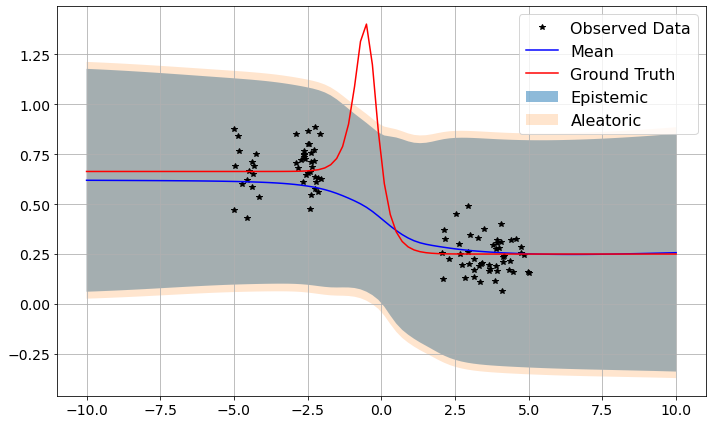

In [39]:
plot_preds(pred_list_emp_low_eps)

In [35]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 50
compressed_weights_emp_med_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_med_eps.append(w[0])

pred_list_emp_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_emp_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_emp_med_eps)

  0%|          | 0/50 [00:00<?, ?it/s]

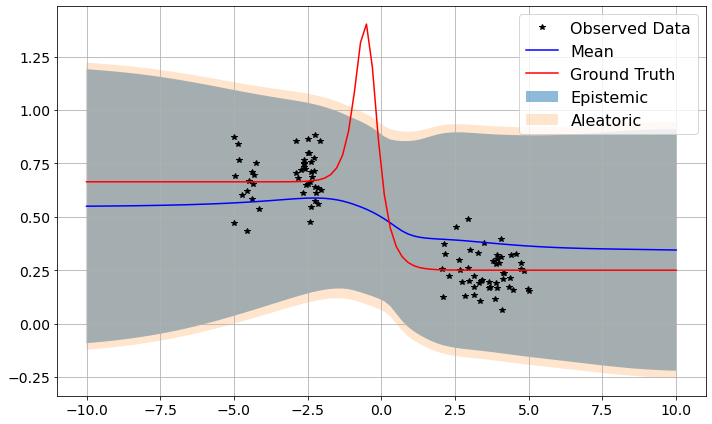

In [38]:
plot_preds(pred_list_emp_med_eps)

In [37]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 50
compressed_weights_emp_high_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_high_eps.append(w[0])

pred_list_emp_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_emp_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_emp_high_eps)

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Let's try the KDE coder

In [ ]:
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.KDEPosterior import KDEPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.beamsearch.Coders.Encoder_KDE import EncoderKDE

In [40]:
num_compressed_samples = 50
compressed_weights_kde_exact = []

for i in trange(num_compressed_samples):
    torch.manual_seed(i)
    compressed_weights_kde_exact.append(KDE_target.sample())

  0%|          | 0/50 [00:00<?, ?it/s]

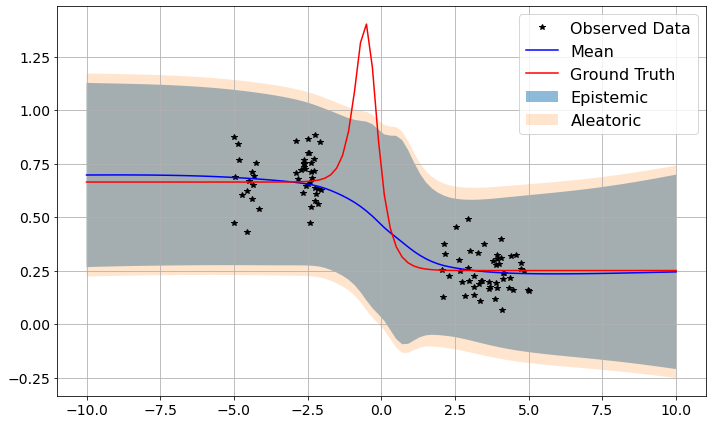

In [41]:
pred_list_kde_exact, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_exact,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_exact)

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 50
compressed_weights_kde_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_low_eps.append(w[0])

In [ ]:
pred_list_kde_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_low_eps)


In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 50
compressed_weights_kde_med_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_med_eps.append(w[0])

In [ ]:
pred_list_kde_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_med_eps)


In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 50
compressed_weights_kde_high_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_high_eps.append(w[0])

In [ ]:
pred_list_kde_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_high_eps)


# Let's Compute some Statistics

In [42]:
def make_empirical_predictive(weights, x_input, y_output):
    pred_list, _ = hamiltorch.predict_model(net, x = x_input.flatten().to(device),
                                                  y = y_output.flatten().to(device), samples=weights,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)
    
    # need to make gmm at each sample
    return pred_list

def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

def compute_gmm_lp(weights, x, y):
    preds = make_empirical_predictive(weights, x, y)
    
    gmm = make_empirical_gmm(preds)
    
    return gmm.log_prob(y.squeeze()).sum()

In [43]:
compute_gmm_lp(params_hmc_gpu, x_test, y_test)

tensor(119.4449)

In [45]:
compute_gmm_lp(params_hmc_gpu, x_data, y_data)

tensor(80.8495)

In [ ]:
compute_gmm_lp(compressed_weights_emp_low_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_emp_med_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_emp_high_eps, x_test, y_test)

In [44]:
compute_gmm_lp(compressed_weights_kde_exact, x_test, y_test)

tensor(68.7728)

In [ ]:
compute_gmm_lp(compressed_weights_kde_low_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_kde_med_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_kde_high_eps, x_test, y_test)

In [ ]:
# dump the important stuff
import pickle as pkl
pkl.dump(kl_q_p, open(f'PickledStuff/BNN_STUFF/EMP/hmc_kl_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(subset, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/HMC_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_emp_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_emp_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_emp_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))
pkl.dump(compressed_weights_kde_exact, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_exact_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_kde_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_kde_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_kde_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))